In [2]:
import os, sys
import torch
import argparse
from scipy import ndimage

In [3]:
#!export PYTHONPATH=$PYTHONPATH:/data1/practical-sose23/castellvi/castellvi_prediction/bids
sys.path.append('/data1/practical-sose23/castellvi/castellvi_prediction/bids')

In [4]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from utils._prepare_data import DataHandler
from modules.ResNetModule import ResNet
from modules.VerSeDataModule import VerSeDataModule
from modules.DenseNetModule import DenseNet
from modules.DenseNetModule_v2 import DenseNetV2
from utils.environment_settings import env_settings
import torch
from torch import nn

####################################
/u/home/ank/.conda/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  File "/u/home/ank/.conda/envs/myenv/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/u/home/ank/.conda/envs/myenv/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/u/home/ank/.conda/envs/myenv/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/u/home/ank/.conda/envs/myenv/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/u/home/ank/.conda/envs/myenv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/u/home/

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = str(env_settings.CUDA_VISIBLE_DEVICES)
if torch.cuda.is_available():
    print('Running on GPU #' + str(torch.cuda.current_device()))

Running on GPU #0


In [5]:
parser = argparse.ArgumentParser(description='Evaluation settings')

parser = argparse.ArgumentParser(description='Evaluation settings')
parser.add_argument('--data_root', nargs='+', default=[str(os.path.join(env_settings.DATA, 'dataset-verse19')),
                                                        str(os.path.join(env_settings.DATA, 'dataset-verse20')),
                                                        str(os.path.join(env_settings.DATA, 'dataset-tri'))])
parser.add_argument('--data_types', nargs='+', default=['rawdata', 'derivatives'])
parser.add_argument('--img_types', nargs='+', default=['ct', 'subreg', 'cortex'])
parser.add_argument('--master_list', default= str(os.path.join(env_settings.ROOT, 'src/dataset/Castellvi_list_Final_Split.xlsx')))
parser.add_argument('--classification_type', default='right_side')
parser.add_argument('--castellvi_classes', nargs='+', default=['1a', '1b', '2a', '2b', '3a', '3b', '4', '0'])
parser.add_argument('--model', default='densenet')
parser.add_argument('--phase', default='train')
parser.add_argument('--scheduler', default='ReduceLROnPlateau')
parser.add_argument('--optimizer', default='AdamW')
parser.add_argument('--learning_rate', type=float, default=0.0001)
parser.add_argument('--weight_decay', type=float, default=0.0001)
parser.add_argument('--total_iterations', type=int, default=100)
parser.add_argument('--batch_size', type=int, default=8)
parser.add_argument('--accumulate_grad_batches', type=int, default=1)
parser.add_argument('--num_workers', type=int, default=8)
parser.add_argument('--save_intervals', type=int, default=10)
parser.add_argument('--n_epochs', type=int, default=100)
parser.add_argument('--resume_path', default='')
parser.add_argument('--experiments', default=env_settings.EXPERIMENTS)
parser.add_argument('--gpu_id', default='0')
parser.add_argument('--n_devices', type=int, default=1)
parser.add_argument('--manual_seed', type=int, default=1)
parser.add_argument('--num_classes', type=int, default=3)
parser.add_argument('--port', type=int, default=2023)
parser.add_argument('--model_type', type=str, default='')
parser.add_argument('--dropout_prob', type=float, default=0.3)


parser.add_argument('--rotate_range', type=int, default=10)
parser.add_argument('--shear_range', type=float, default=0.2)
parser.add_argument('--translate_range', type=float, default=0.15)
parser.add_argument('--scale_range', nargs='+', default=[0.9, 1.1])
parser.add_argument('--aug_prob', type=float, default=0.5)

parser.add_argument('--use_seg', default=True)
parser.add_argument('--no_cuda', default=False)
parser.add_argument('--weighted_sample', default=True)
parser.add_argument('--weighted_loss', default=False)
parser.add_argument('--flip_all', default=True)
parser.add_argument('--cross_validation',default=False)
parser.add_argument('--use_bin_seg', default=True)
parser.add_argument('--use_zero_out',default=True)

parser.add_argument('--elastic_transform', default=True)
parser.add_argument('--seg_comparison', default=False)

parser.add_argument('--version_no', type=int, default=10)
parser.add_argument('--dataset', nargs='+', default=['verse', 'tri'])
parser.add_argument('--eval_type', type=str, default='test')

params, unknown = parser.parse_known_args()


In [6]:
base_experiment = params.experiments + 'baseline_models/' + params.model + '_v0'
ckpt_path = base_experiment + '/best_models/version_' + str(params.version_no)
best_model= os.listdir(ckpt_path)[0]
best_model_path = os.path.join(ckpt_path, best_model)

In [7]:
from eval import Eval


In [8]:
evaluator = Eval(params)
best_model= os.listdir(ckpt_path)[0]
best_model_path = os.path.join(ckpt_path, best_model)

In [9]:
model = evaluator.load_model(best_model_path, params)

DenseNet loaded with 3 classes, data_size (96, 78, 78) and 1 channel


In [10]:
processor = evaluator.get_processor()

[!] Unknown format seg-ano in file sub-verse649_dir-sag_seg-ano.nii.gz
[!] Unknown format iso-ctd in file sub-verse616_dir-iso_iso-ctd.json
[!] "template" is not a valid key/value pair. Expected "KEY-VALUE" in sub-verse519_template_sacrum_msk.nii.gz
[!] "sacrum" is not a valid key/value pair. Expected "KEY-VALUE" in sub-verse519_template_sacrum_msk.nii.gz
[!] Unknown format subreg in file verse559_CT-sag_seg-ano_subreg.nii.gz
[!] "verse559" is not a valid key/value pair. Expected "KEY-VALUE" in verse559_CT-sag_seg-ano_subreg.nii.gz
[!] "verse559" is not a valid key/value pair. Expected "KEY-VALUE" in verse559_CT-sag_seg-ano.nii.gz
[!] "verse549" is not a valid key/value pair. Expected "KEY-VALUE" in verse549_CT-iso_seg-ano.nii.gz
[!] Unknown format ce-ar in file sub-tri106_ce-ar.nii.gz
[!] Unknown format ce-pv in file sub-tri066_ce-pv.nii.gz
[!] Unknown format ce-ne in file sub-tri067_ce-ne.nii.gz
[!] Unknown format ce-late in file sub-tri023_ce-late.nii.gz
[!] Unknown format stat in f

FileNotFoundError: [Errno 2] No such file or directory: '/data1/practical-sose23/castellvi/team_repo/3D-Castellvi-Prediction/src/dataset/Castellvi_list_Final_Split.xlsx'

In [ ]:
test_subjects = evaluator.get_test_subjects()

eval type is not all


In [ ]:
records = evaluator.get_records(processor, test_subjects)

lenght of the test dataset: 73


In [ ]:
# How to get output from the model
# get one sample record
sample_record = records[0]
model_inputs = evaluator.process_input(processor, sample_record)
input_img = model_inputs['original'] # you can also get flipped one by model_inputs['flipped']
output_class, output_prob = evaluator.process_output(model, input_img)


input shape: torch.Size([1, 1, 96, 78, 78])


In [ ]:
output_class

'0'

In [ ]:
import monai
#from monai.networks.utils import eval_mode
from monai.transforms import (
    AddChannel, Compose, LoadImage, RandRotate90, NormalizeIntensity, RandScaleIntensity,
    Resize, ScaleIntensityRange, ToTensor, ScaleIntensity, RandShiftIntensity,CropForeground,
    RandFlip, RandSpatialCrop, ResizeWithPadOrCrop, Spacing, ThresholdIntensity, Orientation
)
from monai.metrics import compute_roc_auc

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
campp = monai.visualize.GradCAMpp(nn_module = model, target_layers = "network.features.denseblock4.denselayer32.layers.conv2", )
win_size = (96, 78, 78)
print("original feature shape", campp.feature_map_size([1, 1] + list(win_size), device) )
print("upsampled feature shape", [1, 1] + list(win_size), device)

original feature shape torch.Size([1, 1, 3, 2, 2])
upsampled feature shape [1, 1, 96, 78, 78] cuda


In [ ]:
def get_layer_names(model):
    layer_names = []
    for name, _ in model.named_parameters():
        # Split the name by '.' and keep the first part
        layer_name = name
        if layer_name not in layer_names:
            layer_names.append(layer_name)
    return layer_names

In [ ]:
layer_names = get_layer_names(model)

In [ ]:
conv_layers_list = []
for i in range(len(layer_names)):
    layer = layer_names[i]
    if 'conv' not in layer:
        continue
    else:
        conv_layers_list.append(layer)
    print(i , layer)

0 network.features.conv0.weight
5 network.features.denseblock1.denselayer1.layers.conv1.weight
8 network.features.denseblock1.denselayer1.layers.conv2.weight
11 network.features.denseblock1.denselayer2.layers.conv1.weight
14 network.features.denseblock1.denselayer2.layers.conv2.weight
17 network.features.denseblock1.denselayer3.layers.conv1.weight
20 network.features.denseblock1.denselayer3.layers.conv2.weight
23 network.features.denseblock1.denselayer4.layers.conv1.weight
26 network.features.denseblock1.denselayer4.layers.conv2.weight
29 network.features.denseblock1.denselayer5.layers.conv1.weight
32 network.features.denseblock1.denselayer5.layers.conv2.weight
35 network.features.denseblock1.denselayer6.layers.conv1.weight
38 network.features.denseblock1.denselayer6.layers.conv2.weight
41 network.features.transition1.conv.weight
44 network.features.denseblock2.denselayer1.layers.conv1.weight
47 network.features.denseblock2.denselayer1.layers.conv2.weight
50 network.features.denseblock

In [ ]:
campp_result = campp( x= input_img , class_idx=None)

In [ ]:
campp_result.shape

torch.Size([1, 1, 96, 78, 78])

In [ ]:
campp_result_3d = campp_result[0][0]

In [ ]:
campp_result_3d.shape

torch.Size([96, 78, 78])

In [ ]:
campp_numpy = campp_result_3d.cpu().detach().numpy()

In [ ]:
campp_numpy.shape

(96, 78, 78)

In [ ]:
import BIDS
from BIDS import BIDS_Global_info, BIDS_Family, NII
import nibabel as nib

In [ ]:
import numpy as np

In [ ]:
def np_to_nifti(np_arr):
    affine = np.array([[0,0,1,0], 
                       [-1,0,0,0], 
                       [0,-1,0,0], 
                       [0,0,0,1]])
    return BIDS.NII(nib.Nifti1Image(np_arr, affine))

In [ ]:
seg_file = np_to_nifti(campp_numpy)

In [ ]:
seg_file.save("/u/home/ank/3D-Castellvi-Prediction/camp.nii.gz")

[*] Save /u/home/ank/3D-Castellvi-Prediction/camp.nii.gz as float32


In [ ]:
camp_result_slice = campp_result[..., 5]

In [ ]:
camp_result_slice_numpy = camp_result_slice.detach().cpu().numpy()

In [ ]:
import cv2

# Overlay Original image and GradCAM heatmap
def superimposed_image_def(camp_results, original_img, alpha = 0.6):
    all_images_slices = []
    all_heatmap_results = []
    print(input_img.shape[2]-1)
    for i in range(input_img.shape[-1]):
        print(i)
        original_image_slice= original_img.detach().cpu().numpy()[..., i]
        original_image_slice = original_image_slice[0,0,:,:] 
        print('original_img shape:', original_image_slice.shape)
        print('original_img data type:', original_image_slice.dtype)
        # Make 1-channel image to 3-channel : To overlay this image with the heatmap (JET colormap = 3-channels)
        original_image_slice = cv2.merge((original_image_slice, original_image_slice, original_image_slice))
        camp_result_slice = camp_results.detach().cpu().numpy()[..., i]
        camp_result_slice = camp_result_slice[0,0,:,:] # Same above
        print('cam_img shape:', camp_result_slice.shape)
        print('cam_img data type:', camp_result_slice.dtype)
        camp_result_slice = np.maximum(camp_result_slice, 0)


        # Convert Class Activation Map to 0 - 255
        camp_result_slice = (camp_result_slice - camp_result_slice.min()) / (
                camp_result_slice.max() - camp_result_slice.min()
        )
        camp_result_slice = np.uint8(255 * camp_result_slice)

        # Convert to Heatmap ---- JET COLORMAP
        camp_result_slice = cv2.applyColorMap(camp_result_slice, cv2.COLORMAP_JET)

        # Superimpose Heatmap on Image Data
        original_image_slice = np.uint8(
            (original_image_slice - original_image_slice.min())
            / (original_image_slice.max() - original_image_slice.min())
            * 255
        )

        superimposed_image =np.uint8(np.uint8(original_image_slice) * alpha + camp_result_slice * (1 - alpha))
        all_images_slices.append(superimposed_image)
        all_heatmap_results.append(camp_result_slice)
        

    return all_images_slices, all_heatmap_results

In [ ]:
input_image_slice_numpy = input_img.detach().cpu().numpy()[..., 5]

In [ ]:
imposed_img , heatmap = superimposed_image_def(campp_result, input_img)

95
0
original_img shape: (96, 78)
original_img data type: float32
cam_img shape: (96, 78)
cam_img data type: float32
1
original_img shape: (96, 78)
original_img data type: float32
cam_img shape: (96, 78)
cam_img data type: float32
2
original_img shape: (96, 78)
original_img data type: float32
cam_img shape: (96, 78)
cam_img data type: float32
3
original_img shape: (96, 78)
original_img data type: float32
cam_img shape: (96, 78)
cam_img data type: float32
4
original_img shape: (96, 78)
original_img data type: float32
cam_img shape: (96, 78)
cam_img data type: float32
5
original_img shape: (96, 78)
original_img data type: float32
cam_img shape: (96, 78)
cam_img data type: float32
6
original_img shape: (96, 78)
original_img data type: float32
cam_img shape: (96, 78)
cam_img data type: float32
7
original_img shape: (96, 78)
original_img data type: float32
cam_img shape: (96, 78)
cam_img data type: float32
8
original_img shape: (96, 78)
original_img data type: float32
cam_img shape: (96, 78

####################################
/tmp/ipykernel_3826025/401259803.py:33: RuntimeWarning: invalid value encountered in divide
  (original_image_slice - original_image_slice.min())
  File "/u/home/ank/.conda/envs/myenv/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/u/home/ank/.conda/envs/myenv/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/u/home/ank/.conda/envs/myenv/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/u/home/ank/.conda/envs/myenv/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/u/home/ank/.conda/envs/myenv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/u/home/ank/.conda/envs/myenv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_l

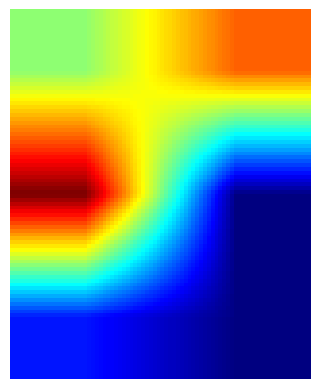

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(heatmap[30])
plt.axis('off')  
plt.show()

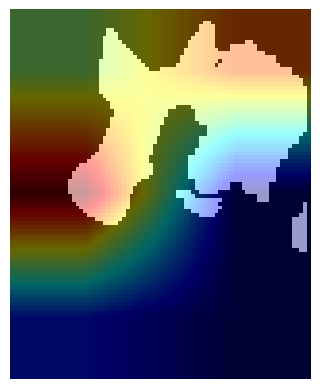

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(imposed_img[30])
plt.axis('off')  
plt.show()

In [ ]:
from matplotlib import animation, rc

In [ ]:
rc('animation', html='jshtml')


def create_animation(array):
    """Create an animation of a volume"""

    fig = plt.figure(figsize=(4, 4))
    images = []
    for idx, image in enumerate(array):
        # plot image without notifying animation
        image_plot = plt.imshow(image, animated=True, cmap='bone')
        aux = [image_plot]
        images.append(aux)

    plt.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.title(f'Deneme', fontsize=16)
    
    ani = animation.ArtistAnimation(
        fig, images, interval=5000//len(array), blit=False, repeat_delay=1000)
    plt.close()
    return ani

In [ ]:
create_animation(imposed_img)

2023-07-13 23:17:38,752 - Animation.save using <class 'matplotlib.animation.HTMLWriter'>


In [ ]:
# Get the occlusion sensitivity map
occ_sens = monai.visualize.OcclusionSensitivity(nn_module=model, mask_size=12, n_batch=10)
# Only get a single slice to save time.
# For the other dimensions (channel, width, height), use
# -1 to use 0 and img.shape[x]-1 for min and max, respectively
depth_slice = input_image.shape[2] // 2
occ_sens_b_box = [depth_slice - 1, depth_slice, -1, -1, -1, -1]

occ_result, _ = occ_sens(x=img, b_box=occ_sens_b_box)
occ_result = occ_result[0, label.argmax().item()][None]

fig, axes = plt.subplots(1, 2, figsize=(25, 15), facecolor="white")

for i, im in enumerate([img[:, :, depth_slice, ...], occ_result]):
    cmap = "gray" if i == 0 else "jet"
    ax = axes[i]
    im_show = ax.imshow(np.squeeze(im[0][0].detach().cpu()), cmap=cmap)
    ax.axis("off")
    fig.colorbar(im_show, ax=ax)